![bookstore](bookstore.jpg)


Identifying popular products is incredibly important for e-commerce companies! Popular products generate more revenue and, therefore, play a key role in stock control.

You've been asked to support an online bookstore by building a model to predict whether a book will be popular or not. They've supplied you with an extensive dataset containing information about all books they've sold, including:

* `price`
* `popularity` (target variable)
* `review/summary`
* `review/text`
* `review/helpfulness`
* `authors`
* `categories`

You'll need to build a model that predicts whether a book will be rated as popular or not.

They have high expectations of you, so have set a target of at least 70% accuracy! You are free to use as many features as you like, and will need to engineer new features to achieve this level of performance.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split  
books = pd.read_csv("data/books.csv")

# Preview the first five rows
books.head()

,title,price,review/helpfulness,review/summary,review/text,description,authors,categories,popularity
0,We Band of Angels: The Untold Story of America...,10.88,2/3,A Great Book about women in WWII,I have alway been a fan of fiction books set i...,"In the fall of 1941, the Philippines was a gar...",'Elizabeth Norman','History',Unpopular
1,Prayer That Brings Revival: Interceding for Go...,9.35,0/0,Very helpful book for church prayer groups and...,Very helpful book to give you a better prayer ...,"In Prayer That Brings Revival, best-selling au...",'Yong-gi Cho','Religion',Unpopular
2,The Mystical Journey from Jesus to Christ,24.95,17/19,Universal Spiritual Awakening Guide With Some ...,The message of this book is to find yourself a...,THE MYSTICAL JOURNEY FROM JESUS TO CHRIST Disc...,'Muata Ashby',"'Body, Mind & Spirit'",Unpopular
3,Death Row,7.99,0/1,Ben Kincaid tries to stop an execution.,The hero of William Bernhardt's Ben Kincaid no...,"Upon receiving his execution date, one of the ...",'Lynden Harris','Social Science',Unpopular
4,Sound and Form in Modern Poetry: Second Editio...,32.50,18/20,good introduction to modern prosody,There's a lot in this book which the reader wi...,An updated and expanded version of a classic a...,"'Harvey Seymour Gross', 'Robert McDowell'",'Poetry',Unpopular


In [35]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15719 entries, 0 to 15718
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               15719 non-null  object 
 1   price               15719 non-null  float64
 2   review/helpfulness  15719 non-null  object 
 3   review/summary      15719 non-null  object 
 4   review/text         15719 non-null  object 
 5   description         15719 non-null  object 
 6   authors             15719 non-null  object 
 7   categories          15719 non-null  object 
 8   popularity          15719 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


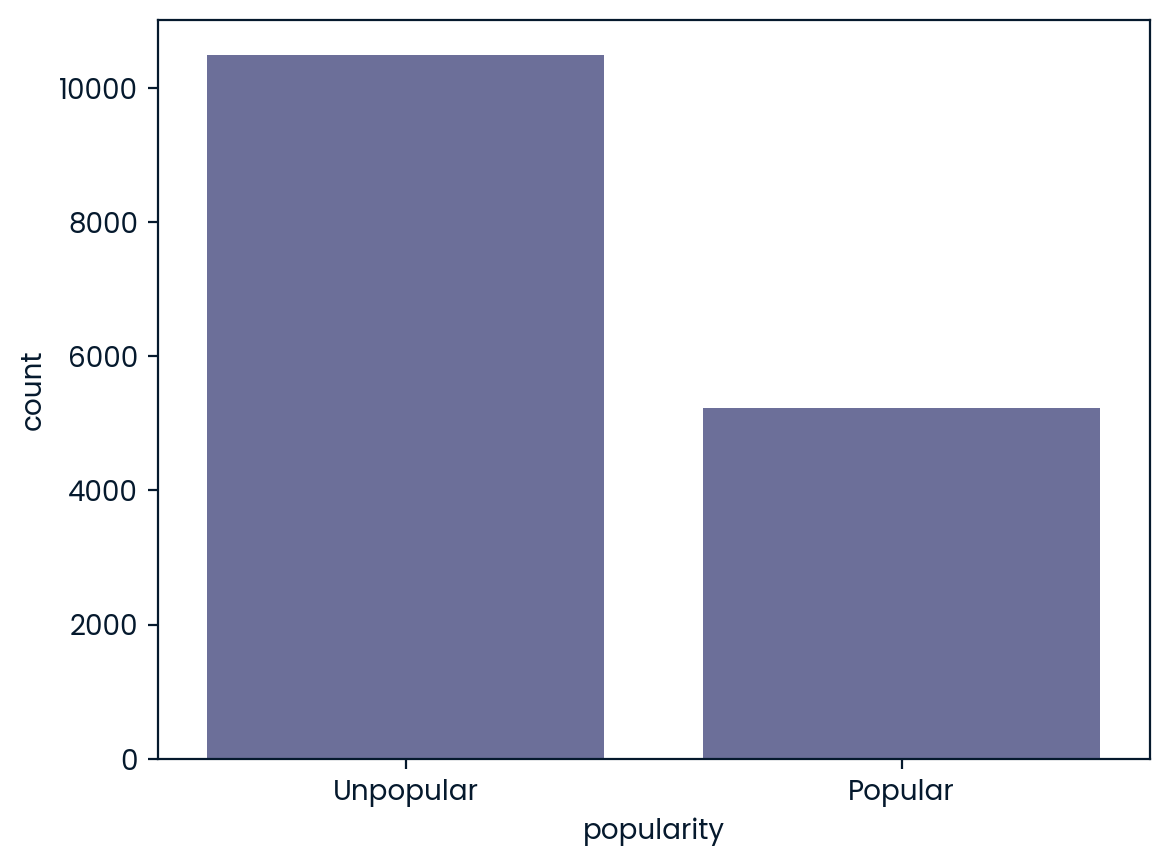

In [36]:
sns.countplot(data=books, x="popularity")
plt.show()

In [37]:
print(books["categories"].value_counts())

books = books.groupby("categories").filter(lambda x: len(x) > 100)

'Fiction'                      3520
'Religion'                     1053
'Biography & Autobiography'     852
'Juvenile Fiction'              815
'History'                       754
                               ... 
'Sunflowers'                      1
'Self-confidence'                 1
'United States'                   1
'Note-taking'                     1
'Asthma'                          1
Name: categories, Length: 313, dtype: int64


In [38]:
categories = pd.get_dummies(books["categories"], drop_first=True)
books = pd.concat([books, categories], axis=1)
books.drop(columns=["categories"], inplace=True)

In [39]:
books["num_reviews"] = books["review/helpfulness"].str.split("/", expand=True)[1]
books["num_helpful"] = books["review/helpfulness"].str.split("/", expand=True)[0]

In [40]:
for col in ["num_reviews", "num_helpful"]:
    books[col] = books[col].astype(int)

books["perc_helpful_reviews"] = books["num_helpful"] / books["num_reviews"]
books["perc_helpful_reviews"].fillna(0, inplace=True)
books.drop(columns=["review/helpfulness"], inplace=True)

In [41]:
for col in ["review/summary", "review/text", "description"]:
    books[col] = books[col].str.lower()

In [42]:
positive_words = ["great", "excellent", "good", "interesting", "enjoy", "helpful", "useful", "like", "love", 
                  "beautiful", "fantastic", "perfect", "wonderful", "impressive", "amazing", "outstanding", 
                  "remarkable", "brilliant", "exceptional", "positive", "thrilling"]

vectorizer = CountVectorizer(vocabulary=positive_words)

review_text = books["review/text"]
text_transformed = vectorizer.fit_transform(review_text.fillna(''))

review_summary = books["review/summary"]
summary_transformed = vectorizer.fit_transform(review_summary.fillna(''))

description = books["description"]
description_transformed = vectorizer.fit_transform(description.fillna(''))

In [43]:
books["positive_words_text"] = text_transformed.sum(axis=1).reshape(-1, 1)
books["positive_words_summary"] = summary_transformed.sum(axis=1).reshape(-1, 1)
books["positive_words_description"] = description_transformed.sum(axis=1).reshape(-1, 1)

books.drop(columns=["review/text", "review/summary", "description"], inplace=True)

In [44]:
X = books.drop(columns=["title", "authors", "popularity"]).values
y = books["popularity"].values.reshape(-1, 1)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [46]:
clf = RandomForestClassifier(n_estimators=120, 
                             max_depth=50, 
                             min_samples_split=5, 
                             random_state=42, 
                             class_weight="balanced")

clf.fit(X_train, y_train.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=50,
                       min_samples_split=5, n_estimators=120, random_state=42)

In [47]:
print(clf.score(X_train, y_train))  # Training accuracy
print(clf.score(X_test, y_test))    # Test accuracy

0.9617126389460683
0.7090036014405763


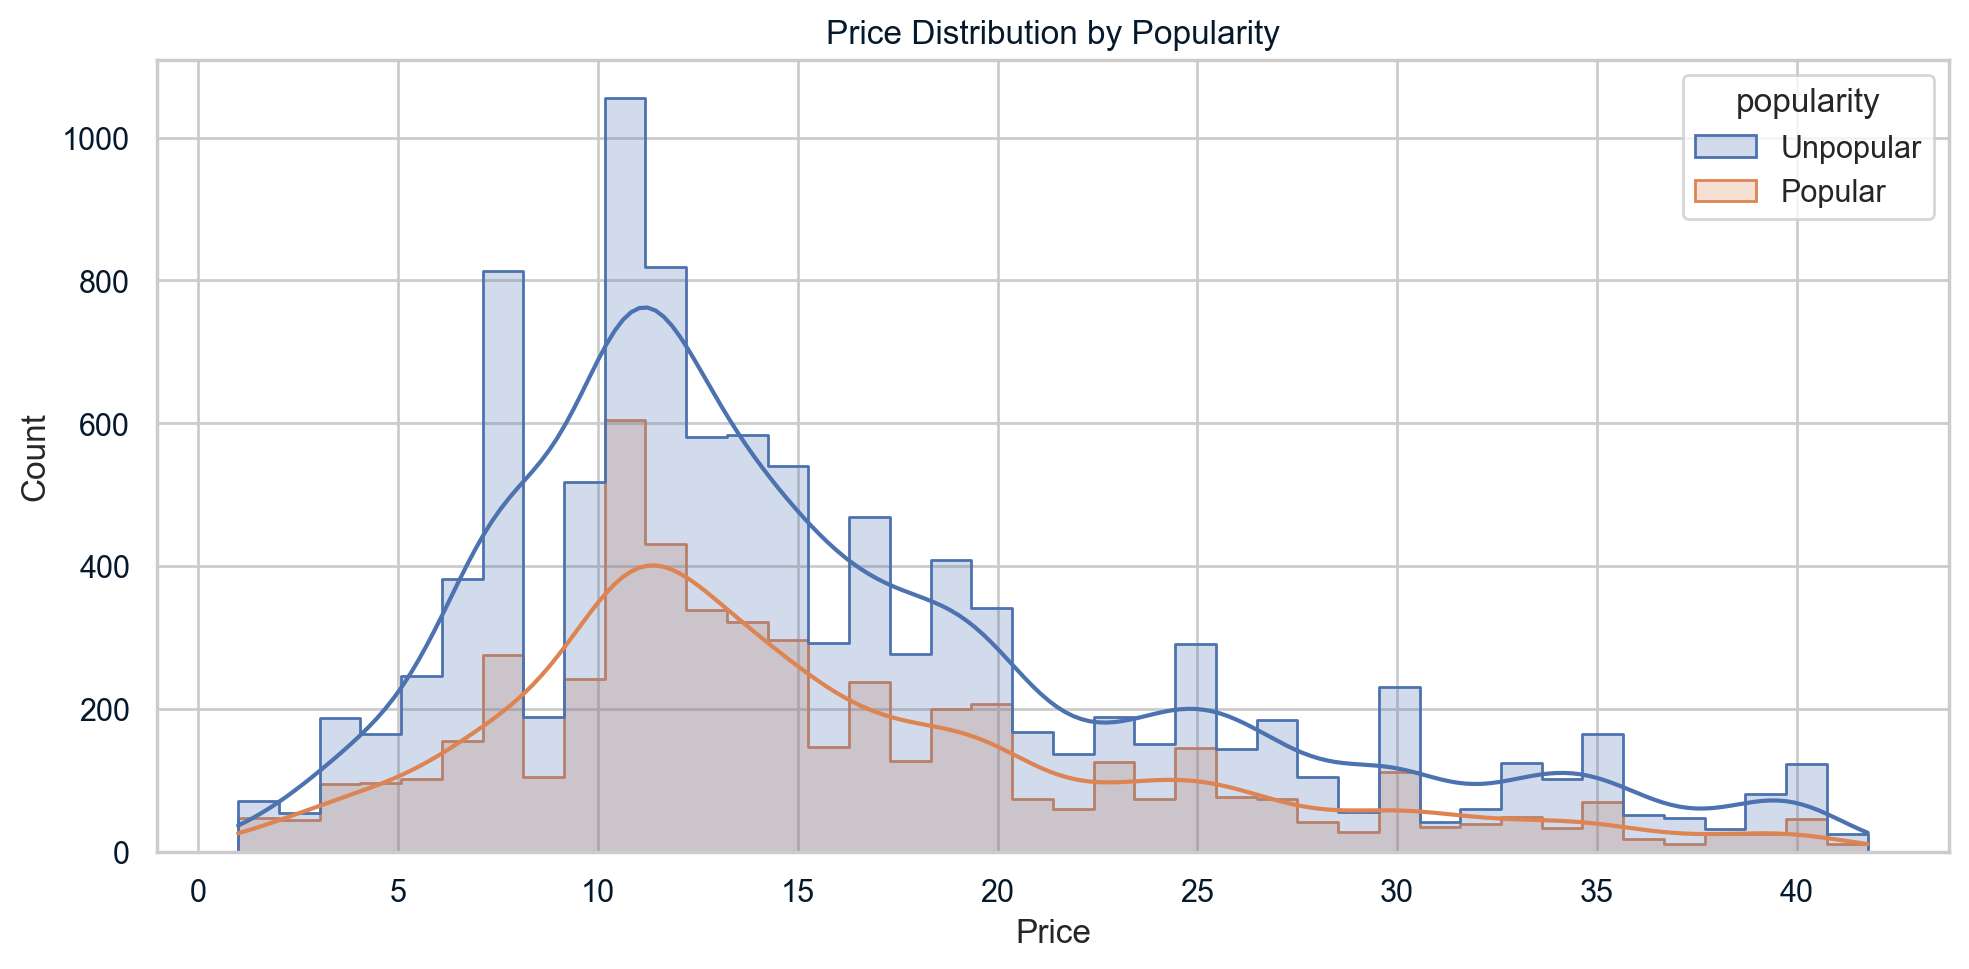

In [4]:

sns.set(style="whitegrid")
Path("figures").mkdir(exist_ok=True)

# --- Helper: map 'popularity' to 0/1, robust to label text ---
def pop_to01(s: pd.Series):
    if s.dtype.kind in "biufc":
        return pd.to_numeric(s, errors="coerce").clip(0, 1)
    m = {
        "popular": 1, "yes": 1, "y": 1, "true": 1, "t": 1, "1": 1,
        "not popular": 0, "unpopular": 0, "no": 0, "n": 0, "false": 0, "f": 0, "0": 0
    }
    return s.astype(str).str.strip().str.lower().map(m)

books["pop01"] = pop_to01(books["popularity"])

# Figure 1: Price distribution by popularity
plt.figure(figsize=(10,5))
sns.histplot(data=books, x="price", hue="popularity", bins=40, element="step", kde=True)
plt.title("Price Distribution by Popularity")
plt.xlabel("Price"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig("figures/price_dist_by_popularity.png", dpi=200); plt.show()

## Correlation heatmap of numeric features

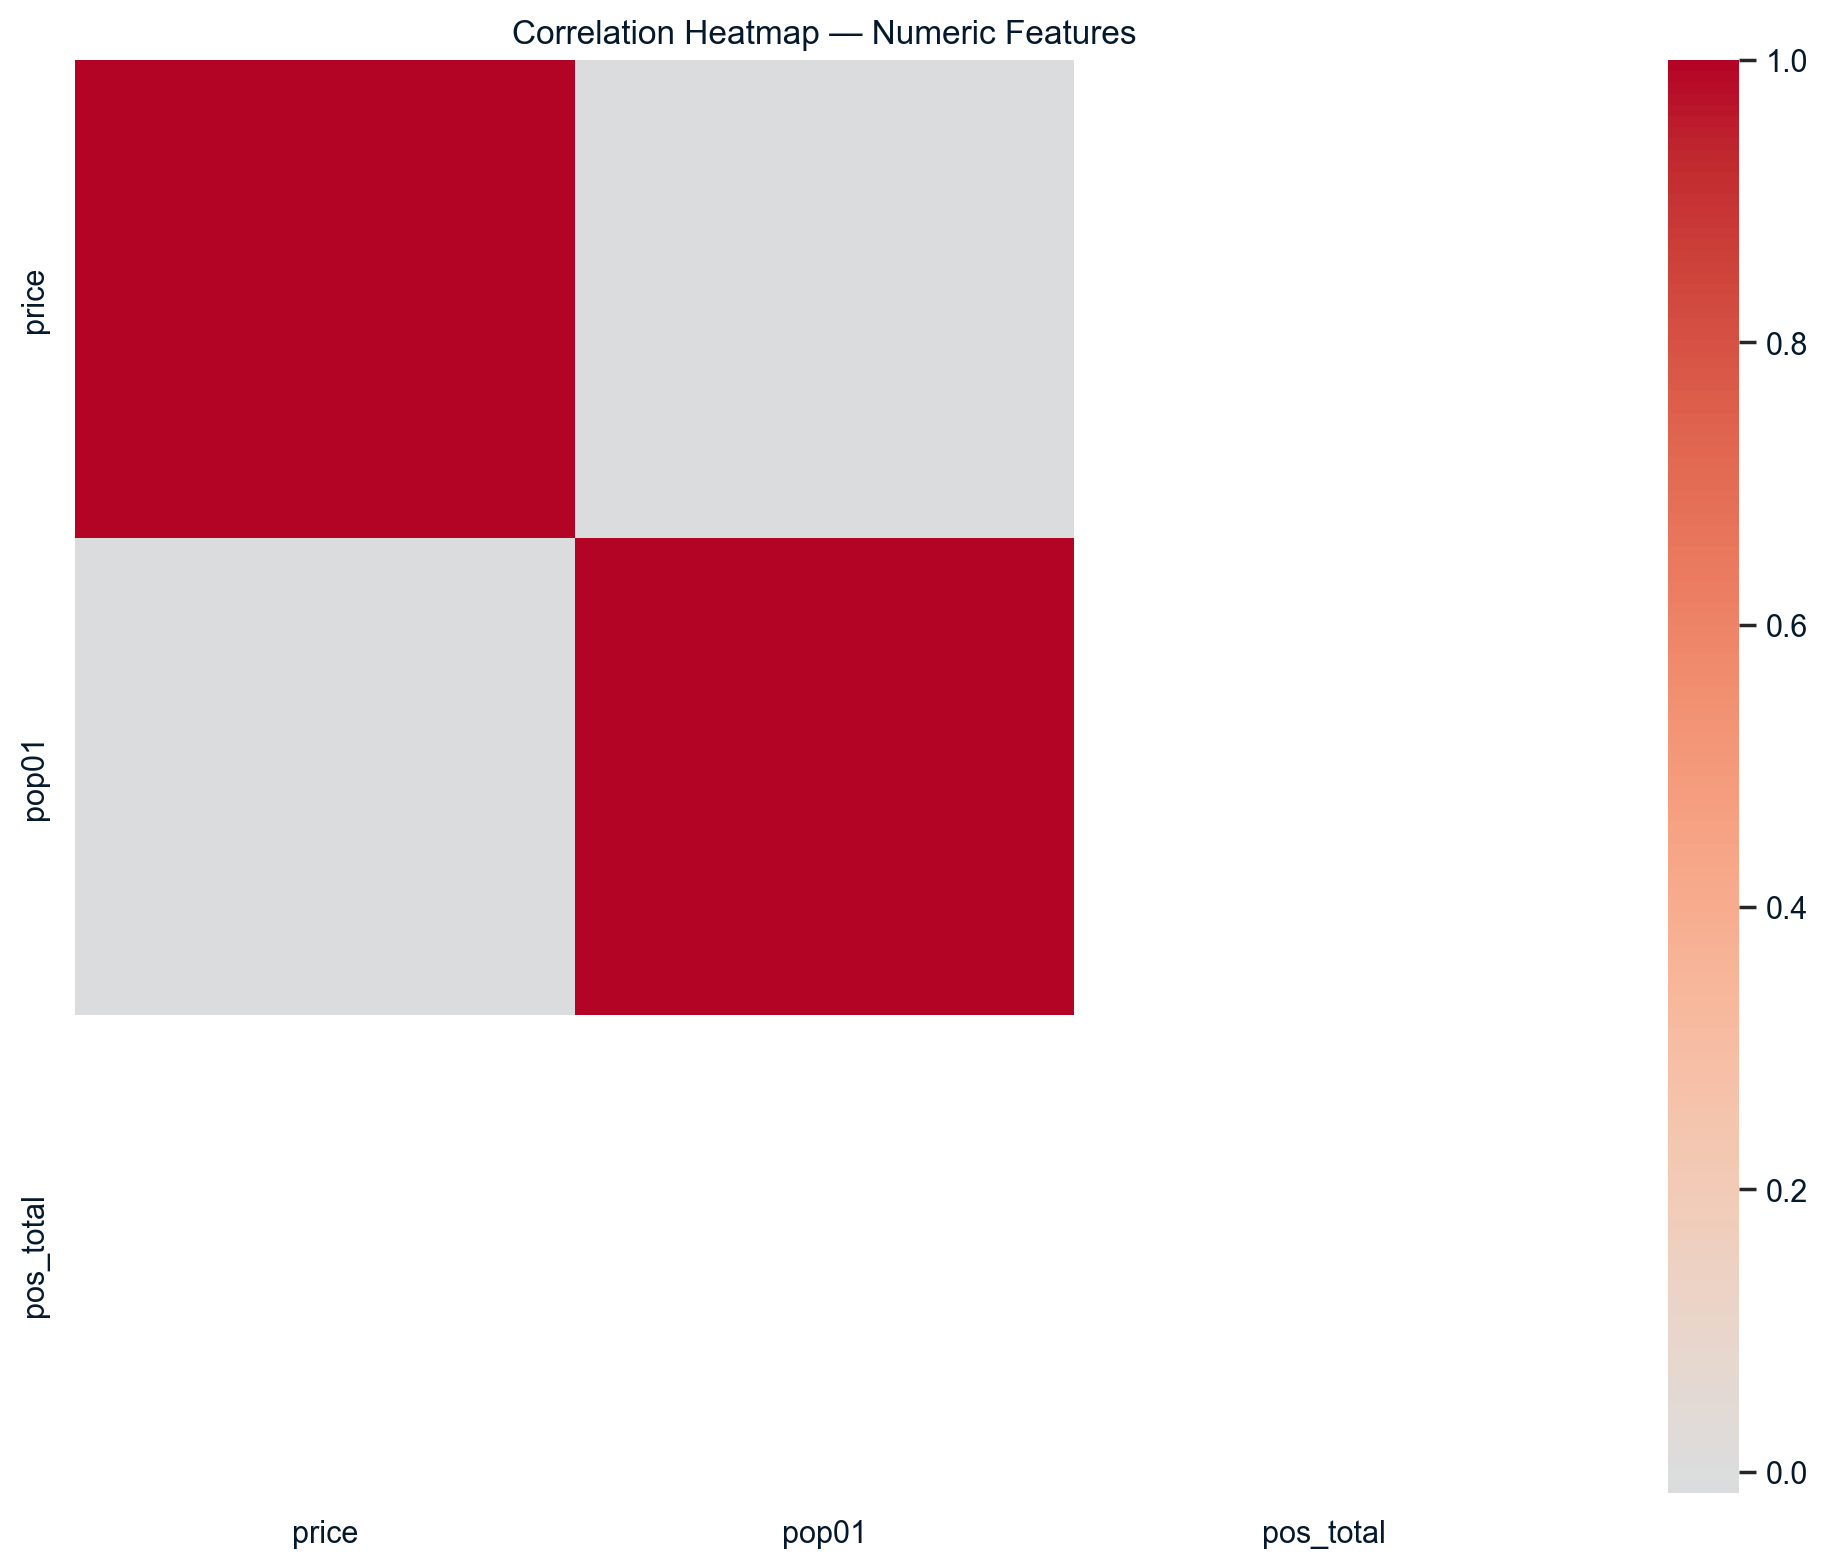

In [11]:
num_cols = books.select_dtypes(include=["number"]).columns
corr = books[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0, square=False)
plt.title("Correlation Heatmap — Numeric Features")
plt.tight_layout(); plt.savefig("figures/corr_heatmap_numeric.png", dpi=200); plt.show()